<a href="https://colab.research.google.com/github/kimhwijin/HandsOnMachineLearing/blob/main/HOML_Exercise_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

1065312256/1065301781 [==============================] - 11s 0us/step


In [3]:
print(*train_files, sep='\n')
print(quickdraw_dir)

/root/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010
/root/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010
/root/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010
/root/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010
/root/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010
/root/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010
/root/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010
/root/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010
/root/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010
/root/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010
/root/.keras/datasets/quickdraw


In [4]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [5]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [6]:
print(len(class_names), *class_names, sep='\n')

345
garden hose
lighter
penguin
tractor
sheep
skateboard
mountain
mouse
chandelier
guitar
roller coaster
owl
toilet
map
snail
yoga
spoon
camera
telephone
bench
pig
lion
skull
hand
raccoon
beard
church
animal migration
whale
sun
washing machine
airplane
megaphone
sleeping bag
jail
fire hydrant
car
barn
swing set
rake
paintbrush
van
dragon
sailboat
compass
duck
hat
kangaroo
donut
crocodile
coffee cup
cooler
waterslide
feather
firetruck
stereo
leg
tree
pillow
purse
hourglass
ear
broccoli
goatee
moon
bridge
peas
squiggle
foot
camouflage
string bean
pants
lipstick
jacket
hockey puck
truck
table
hammer
the great wall of china
paint can
fireplace
leaf
apple
beach
windmill
pear
umbrella
butterfly
flower
lighthouse
parachute
cow
cat
bottlecap
elephant
stethoscope
river
knife
speedboat
sweater
axe
tornado
bulldozer
microphone
basketball
crown
rainbow
cookie
bathtub
watermelon
diving board
remote control
campfire
sea turtle
bird
alarm clock
eyeglasses
laptop
pickup truck
onion
wheel
saxophone
sky

In [7]:
def parse(data_batch):
    #잉크, 
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [8]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

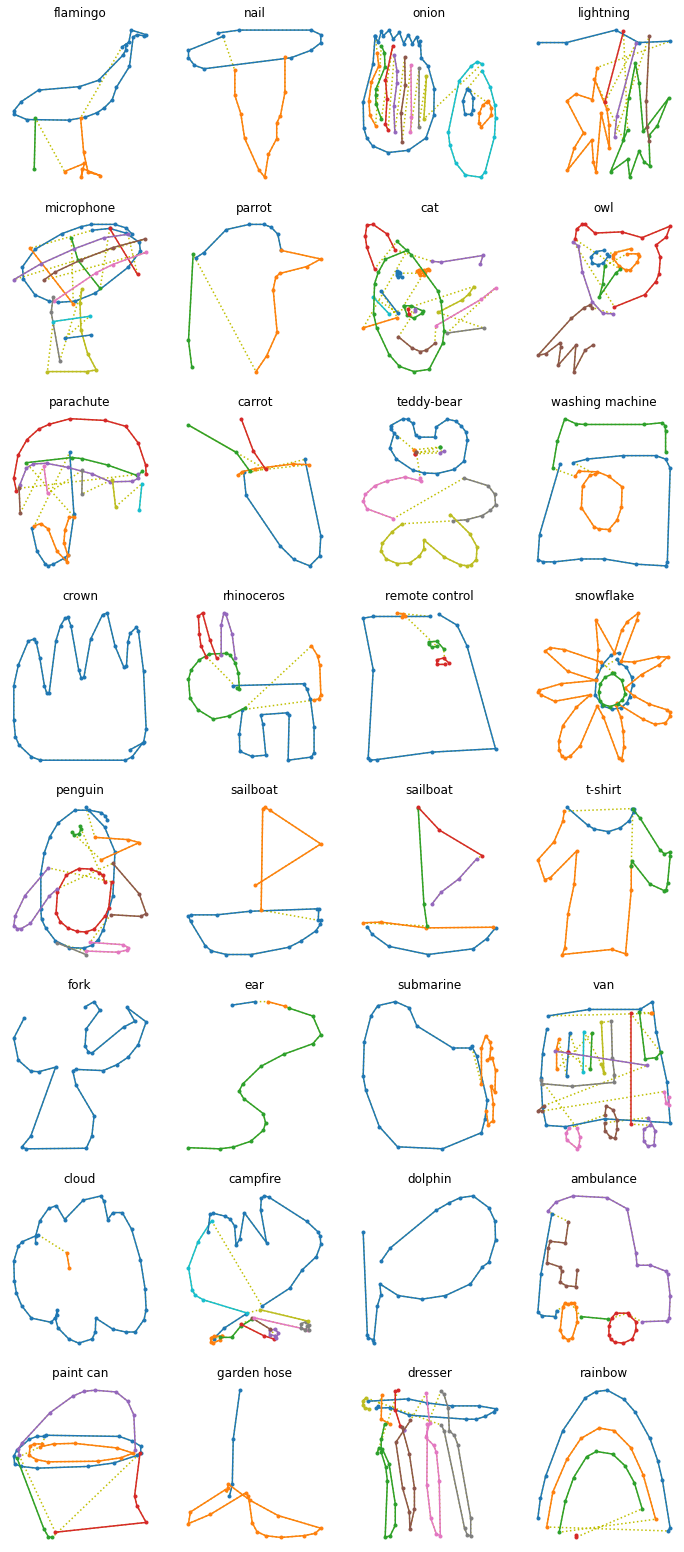

In [9]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

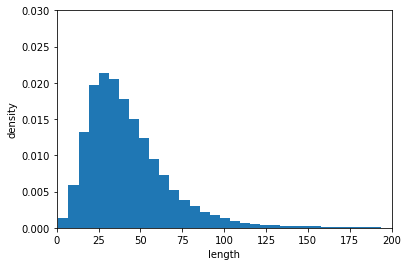

In [10]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [11]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels : (inks[: max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [12]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 1094s 10ms/step - loss: 4.3179 - accuracy: 0.1329 - sparse_top_k_categorical_accuracy: 0.3180 - val_loss: 3.5461 - val_accuracy: 0.2333 - val_sparse_top_k_categorical_accuracy: 0.4947
Epoch 2/2
107813/107813 [==============================] - 1089s 10ms/step - loss: 2.9984 - accuracy: 0.3250 - sparse_top_k_categorical_accuracy: 0.6108 - val_loss: 2.8850 - val_accuracy: 0.3446 - val_sparse_top_k_categorical_accuracy: 0.6332


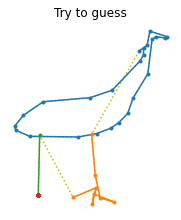

Top-5 predictions:
  1. cello 6.256%
  2. baseball bat 5.117%
  3. banana 3.739%
  4. screwdriver 3.201%
  5. sword 2.823%
Answer: flamingo


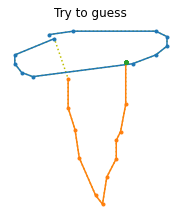

Top-5 predictions:
  1. nail 27.783%
  2. underwear 23.690%
  3. axe 8.473%
  4. diamond 4.241%
  5. hammer 3.755%
Answer: nail


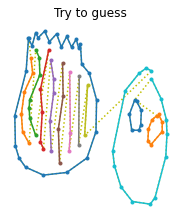

Top-5 predictions:
  1. brain 16.378%
  2. onion 13.563%
  3. tiger 11.542%
  4. zebra 7.263%
  5. hedgehog 6.094%
Answer: onion


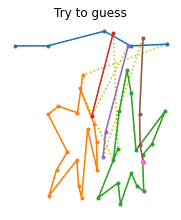

Top-5 predictions:
  1. piano 9.005%
  2. saw 7.620%
  3. zebra 6.988%
  4. paintbrush 6.609%
  5. harp 4.793%
Answer: lightning


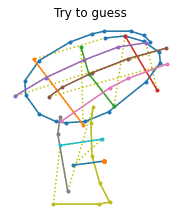

Top-5 predictions:
  1. tennis racquet 56.321%
  2. basket 19.648%
  3. basketball 3.273%
  4. fan 3.056%
  5. microphone 2.210%
Answer: microphone


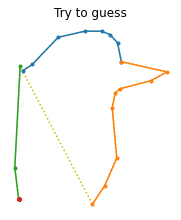

Top-5 predictions:
  1. diamond 12.461%
  2. boomerang 7.710%
  3. parachute 5.671%
  4. bread 5.152%
  5. nail 4.400%
Answer: parrot


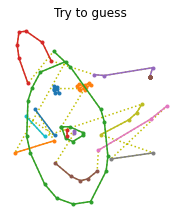

Top-5 predictions:
  1. cat 3.090%
  2. hedgehog 2.510%
  3. raccoon 2.449%
  4. owl 2.373%
  5. camouflage 2.124%
Answer: cat


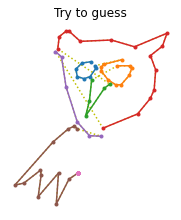

Top-5 predictions:
  1. angel 24.555%
  2. camouflage 6.094%
  3. parrot 5.858%
  4. dragon 3.560%
  5. penguin 3.414%
Answer: owl


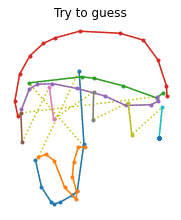

Top-5 predictions:
  1. parachute 30.639%
  2. tennis racquet 9.973%
  3. mushroom 6.135%
  4. umbrella 5.565%
  5. microphone 4.350%
Answer: parachute


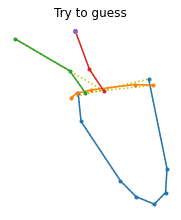

Top-5 predictions:
  1. carrot 26.581%
  2. asparagus 5.421%
  3. diamond 4.373%
  4. lighter 4.328%
  5. candle 3.207%
Answer: carrot


In [13]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))